In [1]:
from equalityml import FAIR, discrimination_threshold, paired_ttest, binary_threshold_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
import warnings

%matplotlib inline

### 1. Train a Machine Learning Model

In [2]:
# Parameters
target_var = 'two_year_recid'
features = ['juv_fel_count', 'priors_count', 'sex', 'age']

In [3]:
data = pd.read_csv('../data/compas-scores-two-years.csv') 

In [4]:
y = data[target_var]
X = data[features]

In [5]:
X.head()

,juv_fel_count,priors_count,sex,age
0,0,0,Male,69
1,0,0,Male,34
2,0,4,Male,24
3,0,1,Male,23
4,0,2,Male,43


In [6]:
# Define which columns should be encoded
columns_to_encode = ['sex']

# Instantiate encoder
ohe = OneHotEncoder(sparse=False, drop = 'if_binary')

# Scale 
encoded_data = ohe.fit_transform(X[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
encoded_df = pd.DataFrame(encoded_data, columns = columns_to_encode)

processed_data = pd.concat([X.drop(columns=columns_to_encode), encoded_df], axis=1)
processed_data = pd.DataFrame(processed_data, columns = X.columns)

In [7]:
processed_data.head()

,juv_fel_count,priors_count,sex,age
0,0,0,1.0,69
1,0,0,1.0,34
2,0,4,1.0,24
3,0,1,1.0,23
4,0,2,1.0,43


In [8]:
X_train, X_test, y_train, y_test = train_test_split(processed_data, y, test_size=0.33, random_state=42)

In [9]:
# Train a machine learning model (for example LogisticRegression)
ml_model_orig = LogisticRegression()
ml_model_orig.fit(X_train, y_train)

LogisticRegression()

In [10]:
testing_data = pd.concat([X_test, y_test], axis=1)
training_data = pd.concat([X_train, y_train], axis=1)

### 2. Optimal Discrimination Threshold for F1 score

100%|██████████| 10/10 [00:00<00:00, 22.99it/s]


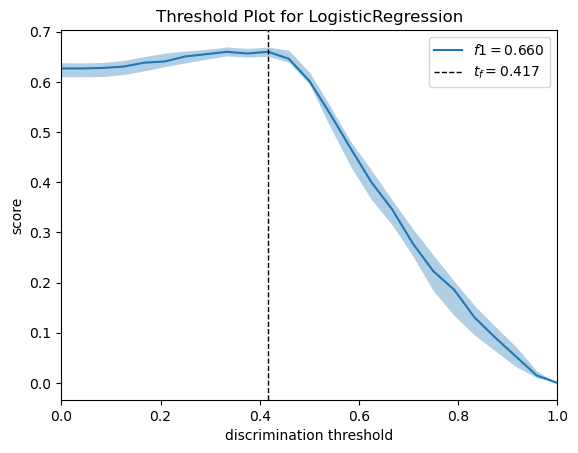

Discrimination Threshold = 0.417


In [11]:
# Discrimination Threshold
threshold = discrimination_threshold(ml_model_orig, pd.concat([training_data, testing_data]), target_var,
                              decision_threshold=['f1', 'max'],
                              metrics=['f1'], show=True)
print(f"Discrimination Threshold = {threshold:.3f}")

In [12]:

f1_score_orig = binary_threshold_score("f1", ml_model_orig, X_test, y_test, threshold=threshold)
print(f"Original F1 score = {f1_score_orig:.3f}")

Original F1 score = 0.666


### 3. Fairness Metric Assessment

In [13]:
fair_object = FAIR(ml_model=ml_model_orig,
                   training_data=training_data,
                   testing_data=testing_data, 
                   target_variable=target_var,
                   protected_variable="sex", 
                   privileged_class=1.0,
                   features=features,
                   threshold=threshold) 

In [14]:
metric_name='statistical_parity_ratio'
fairness_metric_score = fair_object.fairness_metric(metric_name)
fairness_metric_score_orig = fairness_metric_score.copy()
print(f"Original Fairness Metric = {fairness_metric_score_orig:.3f}")

Original Fairness Metric = 0.436


### 4. Compare Performance of Each Mitigation Method

In [15]:
# Print available bias mitigation methods for statistical_parity_ratio
fair_object.print_bias_mitigation_methods(metric_name)

Available bias mitigation methods for 'statistical_parity_ratio' are:
1 'disparate-impact-remover'
2 'resampling'
3 'resampling-preferential'
4 'reweighing'


In [16]:
df = fair_object.compare_mitigation_methods(metric_name='statistical_parity_ratio', 
                                            scoring="f1", 
                                            show=False)
print(df)

                                f1  statistical_parity_ratio
reference                 0.666387                  0.436120
disparate-impact-remover  0.657713                  0.436062
resampling                0.660996                  0.972915
resampling-preferential   0.644980                  0.835506
reweighing                0.660446                  0.978359


### 5. Apply Resampling Mitigation and Re-evaluate F1 Score and Fairness Metric

In [17]:
mitigation_method = "resampling"
mitigation = fair_object.bias_mitigation(mitigation_method = mitigation_method)

# extract modified data 
X_train = mitigation['training_data'][features]
# drop y 
y_train = mitigation['training_data'][target_var]

# Train a machine learning model (for example LogisticRegression)
ml_model = LogisticRegression()
ml_model.fit(X_train, y_train)

# Re-evaluate f1 score
mitigated_f1_score = binary_threshold_score("f1", ml_model, X_test, y_test, threshold=threshold)

# Re-evaluate Fairness
fair_object.update_classifier(ml_model)
fairness_metric_score = fair_object.fairness_metric(metric_name)

In [18]:
print(f"Original F1 score = {f1_score_orig:.3f} and Mitigated F1 score = {mitigated_f1_score:.3f}")
print(f"Orginal Fairness Score = {fairness_metric_score_orig:.3f} and Mitigated Fairness Score = {fairness_metric_score:.3f}")

Original F1 score = 0.666 and Mitigated F1 score = 0.661
Orginal Fairness Score = 0.436 and Mitigated Fairness Score = 0.993


### 6. Paired t Test

In [19]:
# Paired t test based on Fairness metric
results = paired_ttest(ml_model_orig,
                        ml_model,
                        pd.concat([training_data, testing_data]),
                        target_var,
                        method="5x2cv",
                        fair_object=fair_object,
                        mitigation_method=mitigation_method,
                        scoring=metric_name)
print("5x2cv fairness result (chi2, p) = ", results)

100%|██████████| 5/5 [00:00<00:00,  7.38it/s]

5x2cv fairness result (chi2, p) =  (-14.321312154236056, 2.9920310511258146e-05)
